#PSF's on different coverslips

The purpose of this notebook is to show that for exactly the same collar correction setting each coverslip has a different PSF. I claim this is because each one is at a slightly different angle to the other.

In [257]:
%load_ext autoreload
%autoreload 1

#get our environment ready for data analysis times
%pylab inline

#import some os functionality so that we can be platform independent
import os

#import skimage components
from skimage.external import tifffile as tif #note that this can be achieved by using the
                                                #skimage.io with the tifffile plugin.
#better filtering than skimage
from scipy import ndimage

#import pandas
import pandas as pd

from scipy.ndimage import measurements
from scipy.ndimage.filters import median_filter

import matplotlib.gridspec as gridspec #fancy subplot layout

from matplotlib.path import Path #Needed to create shapes
import matplotlib.patches as patches #needed so show shapes on top of graphs

%aimport peaks.gauss2d
Gauss2D = peaks.gauss2d.Gauss2D

%aimport peaks.util
detrend = peaks.util.detrend

%aimport peaks.peakfinder
PeakFinder = peaks.peakfinder.PeakFinder

%aimport dphplotting.mip
mip = dphplotting.mip.mip

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
PSF = tif.imread('testPSF.tif')

(<matplotlib.figure.Figure at 0x102c3de48>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x112e0ac50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112dd1630>], dtype=object))

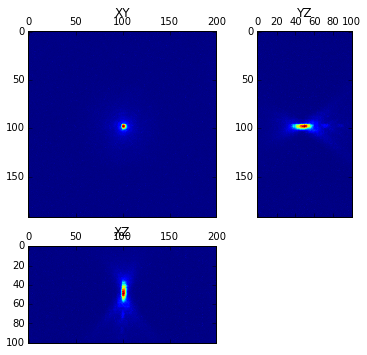

In [3]:
mip(PSF)

In [101]:
def makeSlice(blob, width):
    y,x,w,m = blob
    return [slice(y-width//2,y+width//2), slice(x-width//2, x+width//2)]

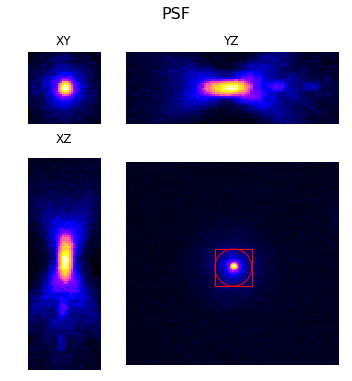

In [102]:
set_cmap('gnuplot2')
width = 35

datapeaks = PeakFinder(PSF.max(0),1.68,'norot')
datapeaks.find_blobs()
blob = datapeaks.remove_edge_blobs(width//2)[-1]
myslice = makeSlice(blob,width)
#print(myslice)
fig,axes = mip(log(PSF[:,myslice[0],myslice[1]]), allaxes = True)
axes[3].matshow(log(PSF.max(0)))

y,x,_,_ = blob
rect = plt.Rectangle((x-width/2,y-width/2),width,width, color='r', linewidth=1, fill=False)
circ = plt.Circle((x, y), radius=width/2, color='r', linewidth=1, fill=False)
axes[3].add_patch(circ)
axes[3].add_patch(rect)

for ax in axes:
    ax.axis('off')
fig.suptitle('PSF',y=1.05,fontsize=16)

#fig.savefig('mip_'+k.replace('.tif','.png'),dpi=300, transparent = True,bbox_inches='tight')

In [110]:
slice.indices()

In [201]:
PSF[myslice].shape

(0, 0)

In [268]:
Gauss2D.dict_to_params(d)

array([ 1433.37044195,   100.96839066,    98.73265863,     2.00808549,
           2.05014203,   109.54500685])

In [271]:
max_z.estimate_params()

array([  1.39994289e+03,   1.97742206e+01,   1.95384344e+01,
         8.26844706e-01,   9.65172460e-01,   1.35412729e+00,
         1.07052950e+02])

In [370]:
#forward fit

def sliceMaker(y0, x0, width, ymax = np.inf, xmax = np.inf):
    ystart = y0-width//2
    xstart = x0-width//2
    
    yend = ystart+width
    xend = ystart+width
    
    if ystart < 0:
        ystart = 0
    if xstart < 0 :
        xstart = 0
        
    if yend > ymax:
        yend = ymax
    if xend > xmax:
        xend = xmax
    
    return [slice(ystart,yend), slice(xstart, xend)]

def fitPeak(slices, stack, width, startingfit, **kwargs):
    '''
    Method to fit a peak in a stack.
    
    The method will track the peak through the stack, assuming that moves are relatively small
    from one slice to the next
    
    Parameters
    ----------
    slices : iterator
        an iterator which dictates which slices to fit, should yeild integers only
        
    stack : ndarray (3 dimensions)
    
    width : integert
        width of fitting window
        
    startingfit : dict
        fit coefficients
        
    '''
    
    #set up our variable to return
    toreturn = []
    
    #grab the starting fit parameters
    popt_d = startingfit.copy()
    
    y0 = int(round(popt_d['y0']))
    x0 = int(round(popt_d['x0']))
    
    if len(popt_d) == 6:
        modeltype = 'norot'
    elif len(popt_d) == 5:
        modeltype = 'sym'
    else:
        modeltype = 'full'
    
    for slic in slices:
        
        #try to update the y0/x0 values
        #if the fit has failed, these will be nan and the operation will raise a value error
        #doing nothing leaves the values intact
        
        #make the slice
        myslice = sliceMaker(y0, x0, width, stack.shape[1],stack.shape[2])
        
        #pull the starting values from it
        ystart = myslice[0].start
        xstart = myslice[1].start
        
        #insert the z-slice number
        myslice.insert(0,slic)
        
        #set up the fit and perform it using last best params
        fit = Gauss2D((PSF[myslice]))
        
        #move our guess coefs back into the window
        popt_d['x0']-=xstart
        popt_d['y0']-=ystart
        
        fit.optimize_params_ls(popt_d, **kwargs)
        
        #if there was an error performing the fit, try again without a guess
        if fit.error:
            fit.optimize_params_ls(modeltype = modeltype, **kwargs)
            
        #if there's still an error move on to the next fit
        if not fit.error:
            popt_d = fit.opt_params_dict()
            popt_d['x0']+=xstart
            popt_d['y0']+=ystart

            popt_d['slice']=slic

            toreturn.append(popt_d.copy())
            
            y0 = int(round(popt_d['y0']))
            x0 = int(round(popt_d['x0']))
        else:
            bad_fit = fit.opt_params_dict()
            bad_fit['slice']=slic
            
            toreturn.append(bad_fit.copy())
        
    return toreturn

In [371]:
#find location of max intensity
my_max = unravel_index(PSF.argmax(),PSF.shape)
#find position
y0, x0 = my_max[1:3]

#make a slice
myslice = makeSlice([y0,x0,0,0],40)

ystart = myslice[0].start
xstart = myslice[1].start

myslice.insert(0,my_max[0])

#set up dataframe for looking for stuff
peakfits = []

#initial fit
max_z = Gauss2D(PSF[myslice])
max_z.optimize_params_ls()

d = max_z.opt_params_dict()
d['slice']=my_max[0]
d['x0']+=xstart
d['y0']+=ystart
peakfits.append(d.copy())

d.pop('slice')
lastparams = max_z.opt_params

In [372]:
peakfits+=fitPeak(range(my_max[0]+1,PSF.shape[0]),PSF,40,d.copy(), quiet = True)\
    + fitPeak(reversed(range(0, my_max[0])),PSF,40,d.copy(),quiet = True)

In [373]:
peakfits_df = pd.DataFrame(peakfits).set_index('slice')

In [374]:
peakfits_df.sort(inplace=True)

In [375]:
peakfits_df

,amp,offset,sigma_x,sigma_y,x0,y0
slice,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,7.198285,108.171647,3.333376,1.996235,98.605161,82.221187
2,4.956567,109.706017,4.156466,3.262523,102.950978,84.393351
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,32.014477,110.865915,-0.302423,0.166798,108.500001,91.016522
7,10.589832,110.861634,-1.007559,1.518202,109.966597,89.970803
8,NaN,NaN,NaN,NaN,NaN,NaN


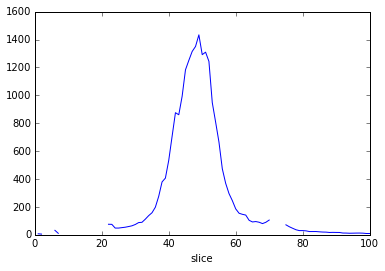

In [376]:
peakfits_df.amp.plot()

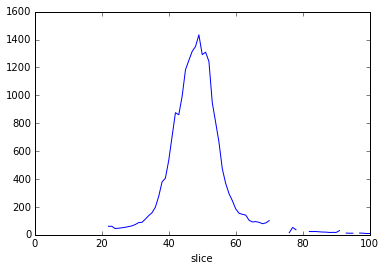

In [247]:
peakfits_df.amp.plot()

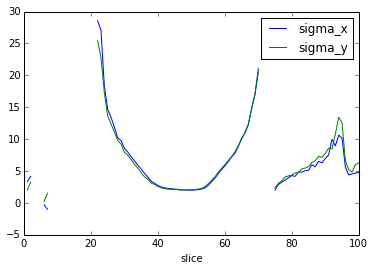

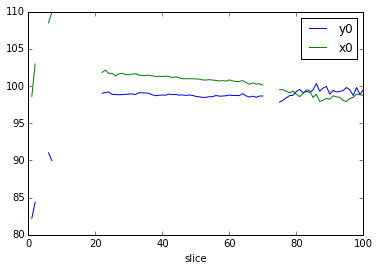

In [377]:
peakfits_df.plot(y=['sigma_x','sigma_y'])
peakfits_df.plot(y=['y0','x0'])

In [383]:
peakfits_df[['x0','y0']].std()

x0    1.886717
y0    2.810518
dtype: float64

In [390]:
peakfits[(((peakfits_df[['x0','y0']]-peakfits_df[['x0','y0']].mean())/peakfits_df[['x0','y0']].std()).abs() < 3)]

TypeError: list indices must be integers, not DataFrame

In [418]:
test = (((peakfits_df[['x0','y0']] - peakfits_df[['x0','y0']].mean()) / peakfits_df[['x0','y0']].std()).abs() < 3)

In [419]:
peakfits_df_filtered = peakfits_df[test.all(axis=1)]

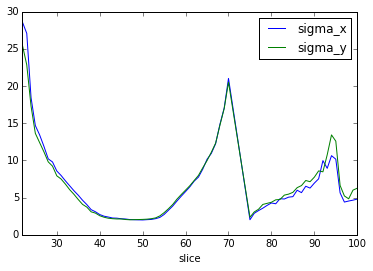

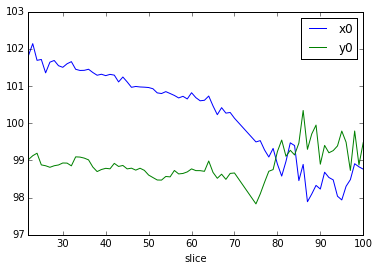

In [420]:
peakfits_df_filtered.plot(y=['sigma_x','sigma_y'])
peakfits_df_filtered.plot(y=['x0','y0'])

In [429]:
peakfits_df_filtered.loc[10:30]

,amp,offset,sigma_x,sigma_y,x0,y0
slice,,,,,,
22,75.528817,57.480252,28.574601,25.454369,101.815951,99.021356
23,74.872493,60.282690,27.072362,22.836972,102.139563,99.125892
24,48.282254,86.557256,18.422779,17.286843,101.690110,99.192835
25,48.249554,94.770689,14.681793,13.633270,101.713145,98.879193
26,51.308970,96.965845,13.423922,12.391057,101.353158,98.855991
27,54.381971,99.594229,11.887906,11.152488,101.640588,98.814782
28,59.103236,102.023964,10.209443,9.804970,101.686206,98.856330
29,64.365063,102.268938,9.788064,9.227288,101.545753,98.877285
30,73.866374,105.183021,8.576817,7.928315,101.502507,98.930406


In [88]:
peakfits_df.assign(angle = lambda x : 90-rad2deg(arccos(x.rho))).dropna()

,amp,offset,rho,sigma_x,sigma_y,x0,y0,angle
slice,,,,,,,,
22,58.742150,74.496942,0.058945,24.131100,21.961553,20.768118,20.175442,3.379286
23,55.801787,79.771369,0.098728,22.081322,19.015718,21.058508,20.340332,5.665906
24,43.936800,91.222788,0.078811,16.851961,16.160730,20.647770,20.307154,4.520197
25,47.361984,95.795664,0.087224,14.388600,13.443966,20.694013,19.938004,5.003909
26,50.185034,98.437134,0.102188,12.988585,12.107792,20.252359,19.892884,5.865174
27,53.165492,101.068030,0.078870,11.660870,10.843324,20.669240,19.859821,4.523599
28,58.875393,102.447908,0.093521,10.152596,9.736206,20.673999,19.872874,5.366215
29,63.837893,102.992358,0.093056,9.755579,9.098036,20.555191,19.906838,5.339418
30,73.737038,105.230499,0.077032,8.621531,7.936770,20.497836,19.946232,4.417959
